In [7]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt

import eos
import kernels
import gaussianprocess
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
from pqcd.pQCD import pQCD
from constants import get_phi

from pathlib import Path
notebook_dir = Path.cwd()

# together

In [8]:
ceft_path = notebook_dir.parent / 'EOS/ceft'
ceft_lower= np.loadtxt(ceft_path / 'eos_ceft_lower.dat')
n_ceft, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt(ceft_path / 'eos_ceft_upper.dat')
_, p_ceft_upper, e_ceft_upper = ceft_upper.T

In [9]:
mu_grid = np.linspace(2.4,3,100) #Grid in chemical potential in [GeV]

pQCD1 = pQCD(1/2) #X=1/2 
pQCD2 = pQCD(2) #X=2 

pqcd1_p = np.vectorize(pQCD1.pressure)(mu_grid)
pqcd1_e = np.vectorize(pQCD1.edens)(mu_grid)

pqcd2_p = np.vectorize(pQCD2.pressure)(mu_grid)
pqcd2_e = np.vectorize(pQCD2.edens)(mu_grid)

n_pQCD1 = np.vectorize(pQCD1.number_density)(mu_grid)
n_pQCD2 = np.vectorize(pQCD2.number_density)(mu_grid)


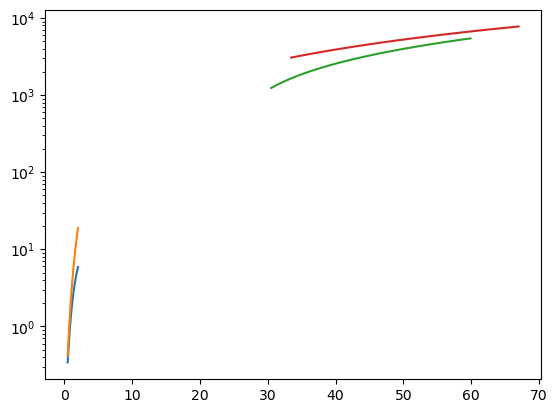

In [10]:
plt.plot(n_ceft[428:]/0.16, p_ceft_lower[428:])
plt.plot(n_ceft[428:]/0.16, p_ceft_upper[428:])
plt.plot(n_pQCD1/0.16,pqcd1_p*1000)
plt.plot(n_pQCD2/0.16,pqcd2_p*1000)
plt.yscale("log")


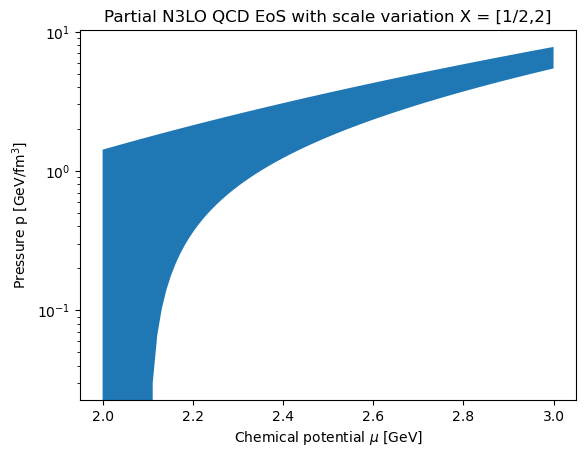

In [11]:
mu_grid = np.linspace(2.0,3,100) #Grid in chemical potential in [GeV]

pQCD1 = pQCD(1/2) #X=1/2 
pQCD2 = pQCD(2) #X=2 

plt.fill_between(mu_grid,np.vectorize(pQCD1.pressure)(mu_grid),np.vectorize(pQCD2.pressure)(mu_grid))
plt.yscale('log')
plt.ylabel('Pressure p [GeV/fm$^3$]')
plt.xlabel('Chemical potential $\mu$ [GeV]')
plt.title('Partial N3LO QCD EoS with scale variation X = [1/2,2]')
plt.show()

# chiral eft

In [12]:
ceft_path = notebook_dir.parent / 'EOS/ceft'

ceft_lower= np.loadtxt(ceft_path / 'eos_ceft_lower.dat')
n_ceft_lower, p_ceft_lower, e_ceft_lower = ceft_lower.T

ceft_upper= np.loadtxt(ceft_path / 'eos_ceft_upper.dat')
n_ceft_upper, p_ceft_upper, e_ceft_upper = ceft_upper.T

n_ceft, p_ceft_lower, e_ceft_lower = ceft_lower.T


n_ceft = n_ceft_lower # fm^-3

e_ceft = (e_ceft_lower+e_ceft_upper)/2
p_ceft = (p_ceft_lower+p_ceft_upper)/2

crust_end = np.where(n_ceft<=0.076)[0][-1]

n_crust = n_ceft[:crust_end+1]
e_crust = e_ceft[:crust_end+1]
p_crust = p_ceft[:crust_end+1]



excluding the crust (n=0.076 fm^-3) because the uncertainty in the crust is way to low and that strongly influences how the gpr behaves (it conditions on the crust too heavily):

In [13]:
np.where(n_ceft<=0.076)[0][-1]

428

In [14]:
n_ceft[429]

0.07600000000000001

In [15]:
p_ceft_upper = p_ceft_upper[crust_end:]
p_ceft_lower = p_ceft_lower[crust_end:]

e_ceft_upper = e_ceft_upper[crust_end:]
e_ceft_lower = e_ceft_lower[crust_end:]

n_ceft = n_ceft[crust_end:]
e_ceft = e_ceft[crust_end:]
p_ceft = p_ceft[crust_end:]
mu_ceft = (e_ceft + p_ceft)/n_ceft

e_ini = e_ceft[0]
p_ini = p_ceft[0]
n_ini = n_ceft[0]
mu_ini = (e_ini + p_ini) / n_ini


# unused due to no uncertainty calculations
e_crust_width = e_ceft_upper[0] - e_ceft_lower[0]
e_ini_sigma = pc.CI_to_sigma(e_crust_width, 75)

p_crust_width = p_ceft_upper[0] - p_ceft_lower[0]
p_ini_sigma = pc.CI_to_sigma(p_crust_width, 75)

mu_ini_sigma = e_ini_sigma + p_ini_sigma

In [16]:
print("Does the crust eos overlap with the inner eos?", n_crust[-1]==n_ceft[0])

Does the crust eos overlap with the inner eos? True


In [17]:
cs2_ceft_lower = np.gradient(p_ceft_lower, e_ceft_lower) #dp/de
cs2_ceft_upper = np.gradient(p_ceft_upper, e_ceft_upper) #dp/de
cs2_ceft_avg = (cs2_ceft_upper+cs2_ceft_lower)/2
cs2_ceft_width = cs2_ceft_upper-cs2_ceft_lower
cs2_ceft_sigma = pc.CI_to_sigma(cs2_ceft_width, 75)

phi_ceft_lower = get_phi(cs2_ceft_lower)
phi_ceft_upper = get_phi(cs2_ceft_upper)
phi_ceft_width = phi_ceft_upper-phi_ceft_lower
phi_ceft_avg = (phi_ceft_upper+phi_ceft_lower)/2
phi_ceft_sigma = pc.CI_to_sigma(phi_ceft_width, 75)


In [18]:
cs2_ceft_lower.shape == n_ceft.shape

True

In [19]:
n_ceft[0]/0.16

0.47375

In [20]:
phi_ceft_avg - (phi_ceft_lower+phi_ceft_upper)/2

array([0., 0., 0., ..., 0., 0., 0.])

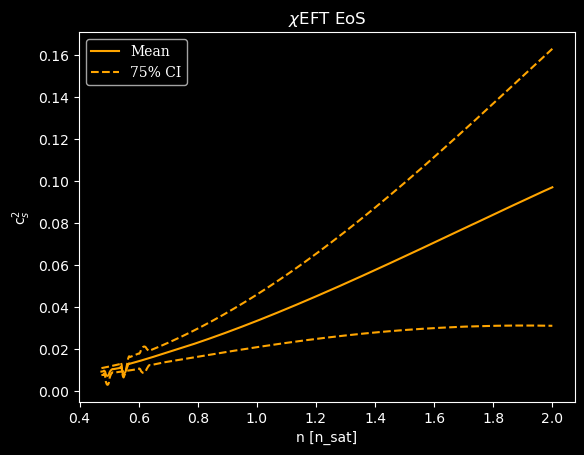

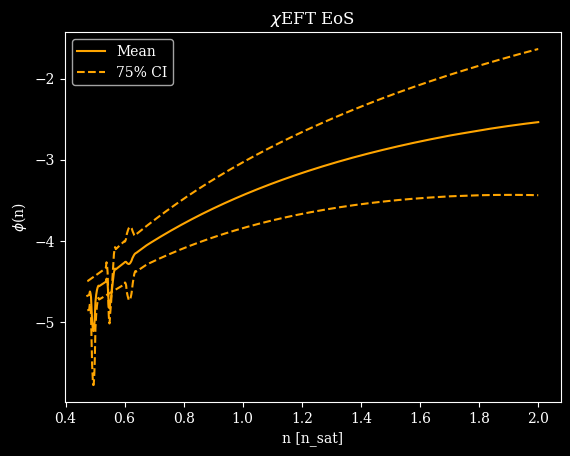

In [21]:
plt.style.use('dark_background')
ax = plt.gca()
ax.set_facecolor('black')
plt.rcParams["font.family"] = "serif"

plt.plot(n_ceft/0.16, cs2_ceft_avg, color='orange', label='Mean')

plt.plot(n_ceft/0.16, cs2_ceft_avg+cs2_ceft_width/2, '--', color='orange', label='75% CI')
plt.plot(n_ceft/0.16, cs2_ceft_avg-cs2_ceft_width/2, '--', color='orange')



plt.ylabel(r'c$_s^2$')
plt.xlabel('n [n_sat]')
plt.title(r"$\chi$EFT EoS")
plt.legend()
plt.show()

plt.plot(n_ceft/0.16, phi_ceft_avg, color='orange',label='Mean')
plt.plot(n_ceft/0.16, phi_ceft_lower, "--", color='orange')
plt.plot(n_ceft/0.16, phi_ceft_upper, "--", color='orange', label='75% CI')
plt.ylabel(r'$\phi$(n)')
plt.xlabel('n [n_sat]')
plt.title(r"$\chi$EFT EoS")
plt.legend()
plt.show()


# GPR

all my number density is in fm^-3

but the x_train and x_test going into the gpr will be in nsat

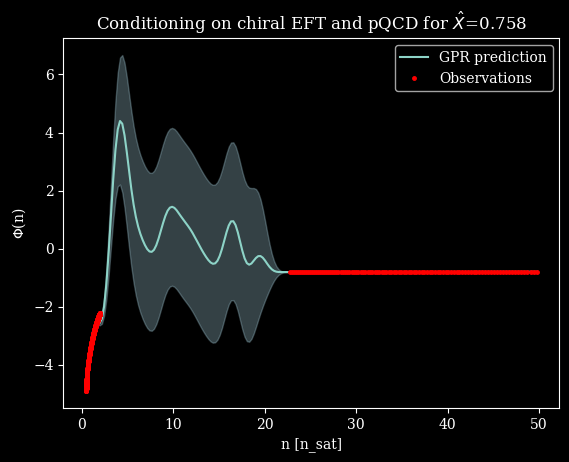

In [ ]:
cs2_hat, nu_hat, l_hat, X_hat = sam.get_hype_samples()

kernel = kernels.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_ceft/0.16, n_pqcd)) #nsat
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(x_train[0], x_train[-1], 200) # number density in nsat, starting val is ending val of n crust


gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.3, color='lightblue')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
#plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")
plt.title(fr"Conditioning on chiral EFT and pQCD for $\hat X$={X_hat:.3f}")
#plt.plot(n_ceft/0.16, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
#plt.plot(n_ceft/0.16, phi_ceft_avg-phi_ceft_width/2, '--', color='red')

plt.legend()
plt.show()



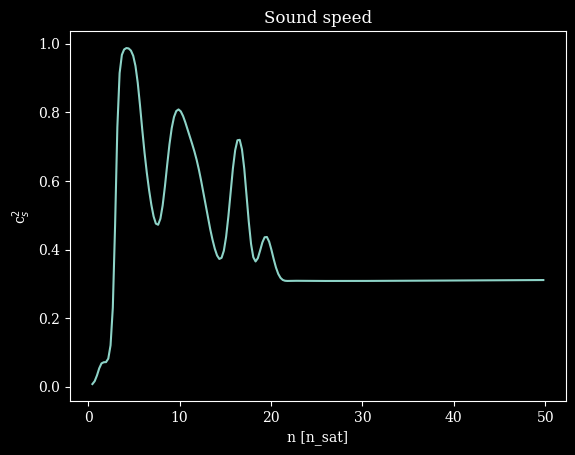

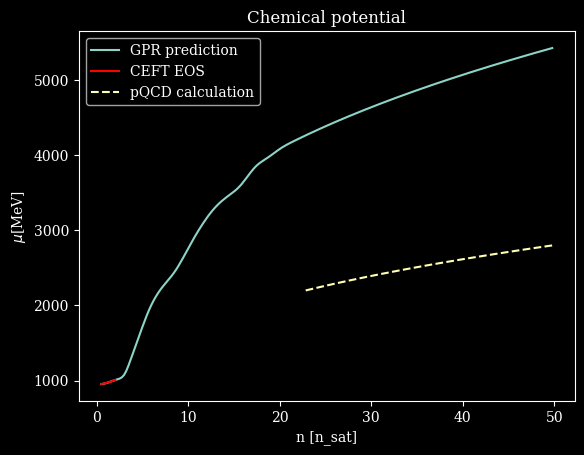

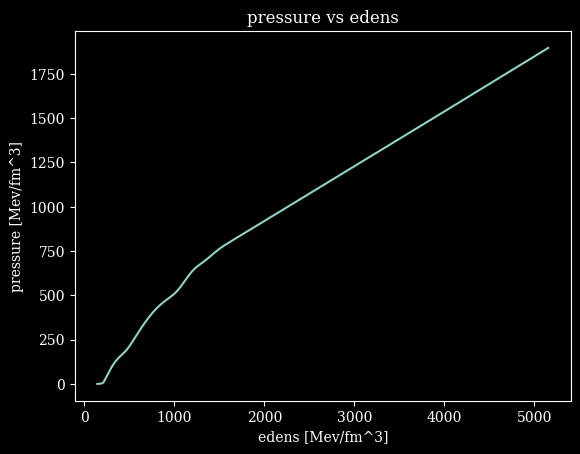

In [25]:
eos = eos.EosProperties(x_test*0.16, phi_test, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_prop_results = eos.get_all()


plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.title(f"Sound speed")
plt.show()

mu_grid = np.linspace(2.2,2.8,100) #Grid in chemical potential in [GeV]

plt.plot(x_test, eos_prop_results["mu"], label = "GPR prediction")
plt.plot(n_ceft/0.16, mu_ceft, "r", label="CEFT EOS")
plt.plot(n_pqcd, mu_grid*1000, "--", label = "pQCD calculation")

plt.title("Chemical potential")
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$[MeV]')
plt.legend()

#plt.xlim(0,2)
#plt.ylim(900,1300)

plt.show()

plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure"])
plt.xlabel(r"edens [Mev/fm^3]")
plt.ylabel(r'pressure [Mev/fm^3]')
plt.title("pressure vs edens")
plt.show()

only until n=10 gpr in the final version to have consistenty 200 points in the GP

fixed?: chemical potential error: $\mu$ from the GPR does not converge to $\mu$ at PQCD densities

# eos properties

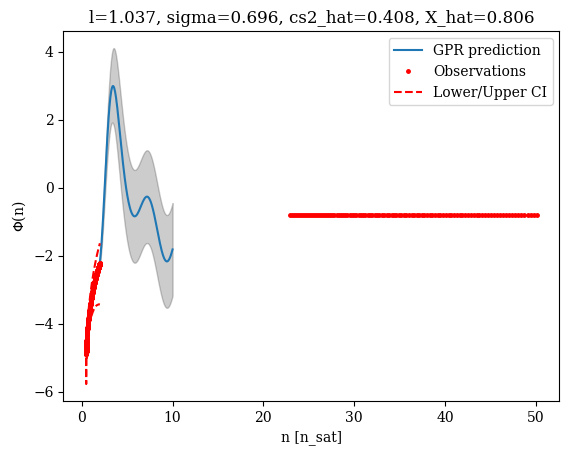

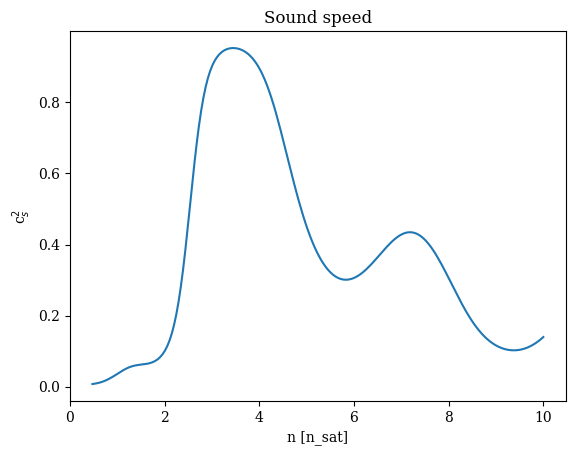

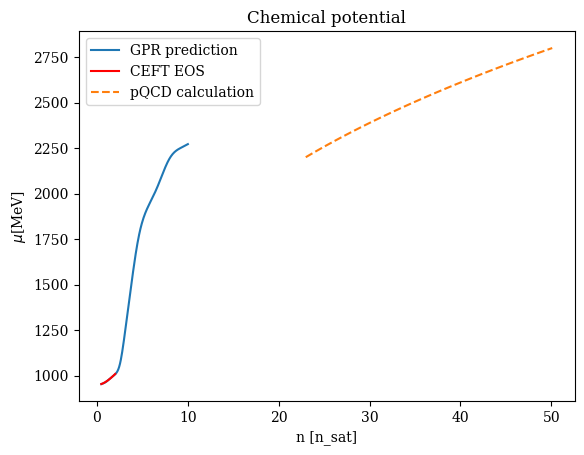

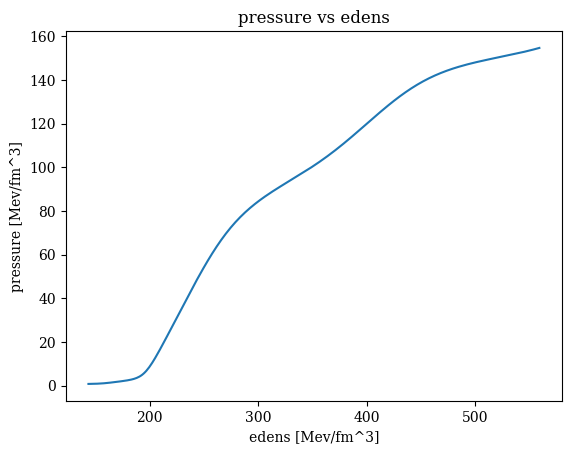

In [ ]:
cs2_hat, nu_hat, l_hat, X_hat = sam.get_hype_samples()

kernel = kernels.Kernel('SE', sigma=nu_hat, l=l_hat)

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=100)

x_train =  np.concatenate((n_ceft/0.16, n_pqcd)) #nsat
cs2_train =  np.concatenate((cs2_ceft_avg, cs2_pqcd))

phi_pqcd_sigma = np.zeros_like(cs2_pqcd)
phi_sigma_train = np.concatenate((phi_ceft_sigma, phi_pqcd_sigma))
phi_train = get_phi(cs2_train)
train_noise = phi_sigma_train**2

x_test = np.linspace(x_train[0], 10, 200) # number density in nsat, starting val is ending val of n crust


gp = gaussianprocess.GP(kernel, get_phi(cs2_hat))
gp.fit(x_train, x_test, phi_train, var_f = train_noise, stabilise=True)

phi_test, sig = gp.posterior()


plt.rcParams["font.family"] = "serif"

plt.plot(x_test, phi_test[0], label=f'GPR prediction')
plt.plot(x_train, phi_train, 'r.', markersize=5, label='Observations')
plt.fill_between(x_test.ravel(), phi_test[0] - 1.96 * sig, phi_test[0] + 1.96 * sig, alpha=0.2, color='k')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\Phi$(n)')
plt.title(f"l={l_hat:.3f}, sigma={nu_hat:.3f}, cs2_hat={cs2_hat:.3f}, X_hat={X_hat:.3f}")

plt.plot(n_ceft/0.16, phi_ceft_avg+phi_ceft_width/2, '--', color='red', label='Lower/Upper CI')
plt.plot(n_ceft/0.16, phi_ceft_avg-phi_ceft_width/2, '--', color='red')


plt.legend()
plt.show()


eos = eos.EosProperties(x_test*0.16, phi_test, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini)
eos_prop_results = eos.get_all()


plt.plot(x_test, eos_prop_results['cs2'])
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.title(f"Sound speed")
plt.show()

mu_grid = np.linspace(2.2,2.8,100) #Grid in chemical potential in [GeV]

plt.plot(x_test, eos_prop_results["mu"], label = "GPR prediction")
plt.plot(n_ceft/0.16, mu_ceft, "r", label="CEFT EOS")
plt.plot(n_pqcd, mu_grid*1000, "--", label = "pQCD calculation")

plt.title("Chemical potential")
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$[MeV]')
plt.legend()

#plt.xlim(0,2)
#plt.ylim(900,1300)

plt.show()

plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure"])
plt.xlabel(r"edens [Mev/fm^3]")
plt.ylabel(r'pressure [Mev/fm^3]')
plt.title("pressure vs edens")
plt.show()

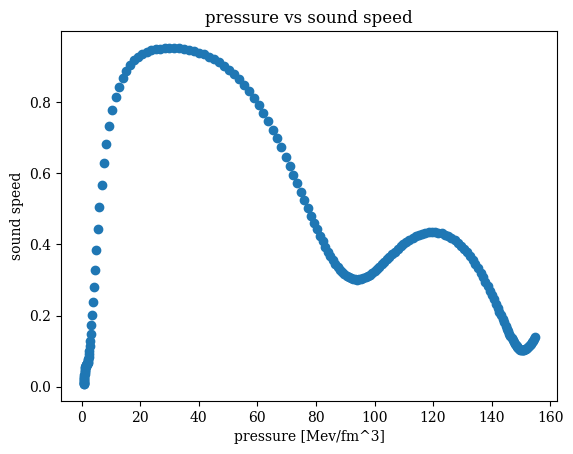

In [70]:
plt.scatter(eos_prop_results["pressure"], eos_prop_results["cs2"])
plt.xlabel(r"pressure [Mev/fm^3]")
plt.ylabel(r'sound speed')
plt.title("pressure vs sound speed")
plt.show()

# eos uncertainties

$$c_s^2 = \frac{1}{e^{-\phi}+1}$$ 
$$\sigma_{c_s^2} = |\frac{\partial {c_s^2}}{\partial \phi}| \sigma_{\phi} = \frac{e^{-\phi}}{(e^{-\phi}+1)^2}| \sigma_{\phi}$$

not needed as sampling

In [39]:
def cs2_uncertainty(phi, sig_phi):
    phi = phi.flatten()
    sig_cs2 = np.abs(np.exp(-phi)/((np.exp(-phi)+1)**2)) * sig_phi
    return sig_cs2

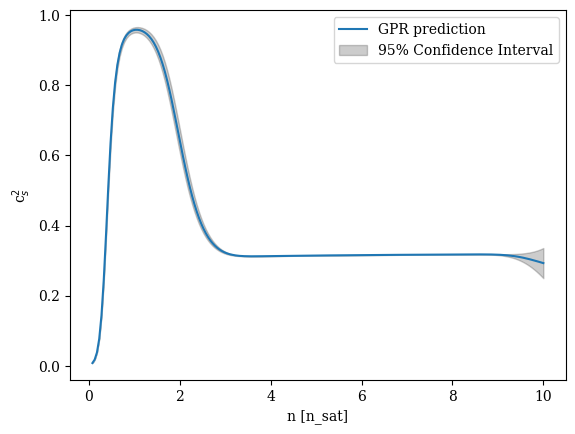

In [40]:
sig_cs2 = cs2_uncertainty(phi_test, sig)
plt.plot(x_test, eos_prop_results['cs2'], label='GPR prediction')
plt.fill_between(x_test, eos_prop_results['cs2'] - 1.96 * sig_cs2, eos_prop_results['cs2'] + 1.96 * sig_cs2, alpha=0.2, color='k', label='95% Confidence Interval')
plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.legend()

plt.show()

In [16]:
def mu_uncertainty(mu, mu0, sig_mu0, sig_cs2, n, n_init):
    """
    Calculate the uncertainty in mu (sigma_mu).

    Parameters:
    - mu: Array of mu values.
    - sig_cs2: Array of uncertainties in c_i^2 (sigma_c_i).
    - x_test: Array of n_i values.
    - delta_n: Array of Delta n_i values corresponding to each n_i.

    Returns:
    - sigma_mu: Array of uncertainties in mu (sigma_mu).

    See notebook on uncertainty
    """
    # Ensure all inputs are numpy arrays for efficient calculations
    mu = np.array(mu)
    sig_cs2 = np.array(sig_cs2)
    n = np.array(n)
    delta_n = np.diff(n, prepend=n_init)

    uncertainty_terms = (delta_n / n) * sig_cs2

    sigma_x2 = np.sum(uncertainty_terms**2)
    
    # Compute sigma_mu using the propagated uncertainty formula
    sigma_mu = ((mu*sigma_x2)+(sig_mu0 * mu/mu0))**0.5
    
    return sigma_mu


In [17]:
sig_mu = mu_uncertainty(eos_prop_results['mu'], mu_ini, mu_ini_sigma, sig_cs2, x_test, n_ini)

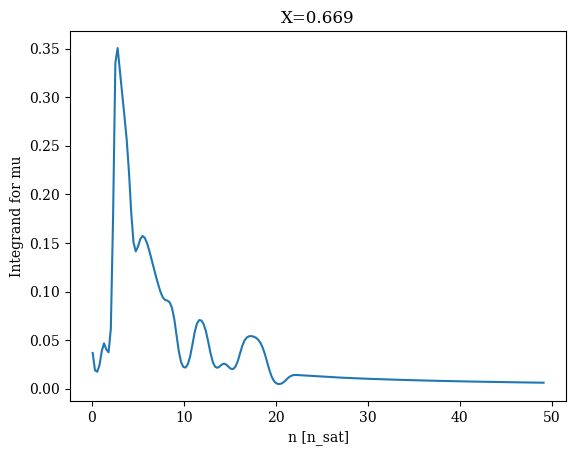

In [46]:
plt.plot(x_test, eos_prop_results['cs2']/x_test)
plt.xlabel('n [n_sat]')
plt.ylabel(r'Integrand for mu')
plt.title(f"X={X_hat:.3f}")
plt.show()

In [53]:
def epsilon_uncertainty(epsilon, sigma_epsilon0, sigma_mu, n, n_init):
    n = np.array(n)
    delta_n = np.diff(n, prepend=n_init)

    cumulative_uncertainty_squared = 0.0
    sigma_epsilon = np.zeros(len(epsilon))

    for i in range(len(epsilon)):
        cumulative_uncertainty_squared += (sigma_mu[i] * delta_n[i])**2
        sigma_epsilon[i] = np.sqrt(sigma_epsilon0**2 + cumulative_uncertainty_squared)

    return sigma_epsilon

In [54]:
sig_epsilon = epsilon_uncertainty(eos_prop_results['epsilon'], e_ini, sig_mu, x_test, n_ini)

In [55]:
def sigma_cov(x,y):
    n = len(x)
    sig = 1/n * np.sum((x-np.mean(x))*(y-np.mean(y)))
    return sig

In [56]:
sigma_cov(eos_prop_results["cs2"], eos_prop_results["mu"])

-6.525684784661569

In [57]:
from scipy.integrate import cumulative_simpson as cumsimp

def p_uncertainty(p0, sigma_p0, p, epsilon, epsilon_0, mu, mu_0, sigma_mu, cs2, sigma_cs2, n):
    """
    Calculate the propagated uncertainty in p = p0 + integral(cs2 * mu dn).

    Parameters:
    - p0: Initial value of p.
    - sigma_p0: Uncertainty in p0.
    - p: Array of precomputed p values.
    - epsilon: Array of cumulative integral values for mu (epsilon).
    - epsilon_0: Initial value of epsilon (epsilon_0).
    - mu: Array of mu values.
    - mu_0: Initial value of mu.
    - sigma_mu: Array of uncertainties in mu.
    - cs2: Array of cs2 values.
    - sigma_cs2: Array of uncertainties in cs2.
    - n: Array of n values (integration variable).

    Returns:
    - sigma_p: Uncertainty in p.
    """
    # Calculate integrals from the given data
    integral_cs2_mu = p - p0  # Integral of cs2 * mu (already computed as p - p0)
    integral_mu = epsilon - epsilon_0  # Integral of mu (from epsilon)
    integral_cs2 = cumsimp(y=cs2, x=n, initial=np.log(mu_0))  # Integral of cs2

    # Partial derivatives
    partial_mu = integral_cs2  # ∂p/∂mu = ∫cs2 dn
    partial_cs2 = integral_mu  # ∂p/∂cs2 = ∫mu dn

    sigma_cs2_mu = sigma_cov(cs2, mu)

    # Propagate uncertainty
    sigma_p_squared = (
        sigma_p0**2 +                               # Contribution from p0
        (partial_mu**2) * sigma_mu**2 +             # Contribution from mu
        (partial_cs2**2) * sigma_cs2**2 +           # Contribution from cs2 <- largest
        2 * np.abs(partial_mu * partial_cs2) * (sigma_mu*sigma_cs2) # Covariance term, note it is the upper bound
    )
    sigma_p = np.sqrt(sigma_p_squared)

    return sigma_p


In [58]:
sig_p = p_uncertainty(p_ini, 
                      p_ini_sigma, 
                      eos_prop_results["pressure2"], 
                      eos_prop_results["epsilon"], 
                      e_ini, 
                      eos_prop_results["mu"], 
                      mu_ini, 
                      mu_ini_sigma, 
                      eos_prop_results["cs2"], 
                      sig_cs2, 
                      x_test)

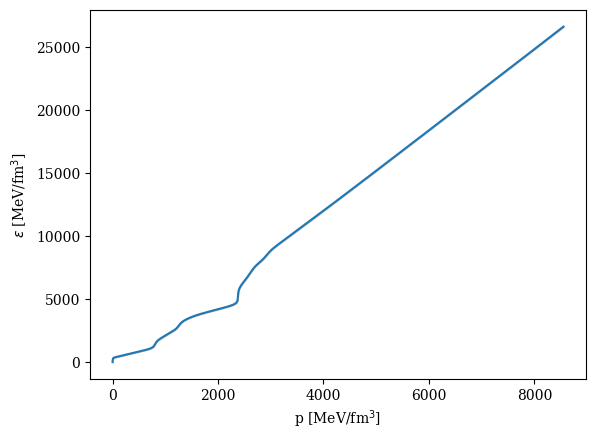

In [59]:
plt.plot( eos_prop_results["pressure2"], eos_prop_results["epsilon"],)
plt.ylabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.xlabel(r'p [MeV/fm$^3$]')

plt.fill_between(eos_prop_results["pressure2"], eos_prop_results['epsilon'] - 1.96 * sig_epsilon, eos_prop_results['epsilon'] + 1.96 * sig_epsilon, alpha=0.2, color='k', label='95% Confidence Interval')

plt.show()    

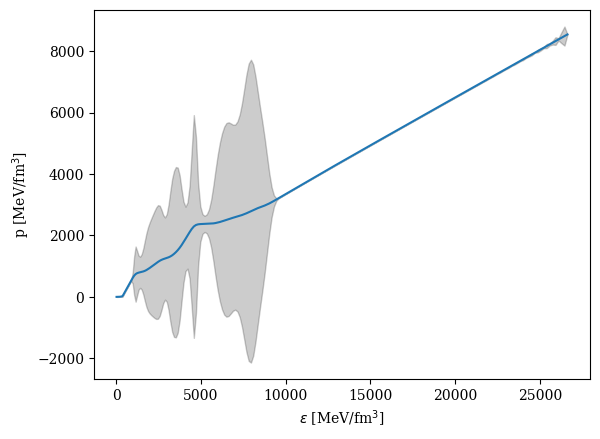

In [60]:
plt.plot(eos_prop_results["epsilon"], eos_prop_results["pressure2"])
plt.xlabel(r'$\epsilon$ [MeV/fm$^3$]')
plt.ylabel(r'p [MeV/fm$^3$]')

plt.fill_between(eos_prop_results["epsilon"], eos_prop_results['pressure2'] - 1.96 * sig_p, eos_prop_results['pressure2'] + 1.96 * sig_p, alpha=0.2, color='k', label='95% Confidence Interval')

plt.show()    